In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import msBO
from msBO import plot_msGP_over_states
from msBO.utils import plot_2D_projection
from msBO import construct_machineIO as mIO
from pprint import pprint

In [2]:
import warnings
from contextlib import contextmanager

@contextmanager
def capture_warnings():
    warnings.simplefilter("always")
    yield
    with warnings.catch_warnings(record=True) as ws:
        for w in ws:
            print(w.message)
            print(f"{w.filename}, line {w.lineno}")

In [3]:
timespan_for_average = 2    # sec  
additional_wait_after_powersupply_ramp  = 0.2 # sec

In [4]:
n_init = 4
n_eval = 4
beta = 9

In [5]:
n_control = 4
control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs   = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols  = [0.1]*len(control_CSETs)
control_min   = [0.0]*len(control_CSETs)
control_max   = [1.0]*len(control_CSETs)

In [6]:
iCSET = 0
refCSET = control_CSETs[iCSET]
control_couplings = {refCSET: {'CSETs' : [f'C{i}:I_CSET' for i in range(3)]}
                    }
assert np.all(['_CSET' in pv for pv in control_couplings[refCSET]['CSETs']])
control_couplings[refCSET]['RDs'] = [pv.replace('_CSET','_RD') for pv in control_couplings[refCSET]['CSETs']]
control_couplings[refCSET]['coeffs'] = [0.5,0.5,1.0]
control_couplings[refCSET]['tols'] = [0.5]*3
pprint(control_couplings)      

{'PSC0:I_CSET': {'CSETs': ['C0:I_CSET', 'C1:I_CSET', 'C2:I_CSET'],
                 'RDs': ['C0:I_RD', 'C1:I_RD', 'C2:I_RD'],
                 'coeffs': [0.5, 0.5, 1.0],
                 'tols': [0.5, 0.5, 0.5]}}


In [7]:
n_state_PV = 1
n_state = 2
state_CSETs   = [f'SLIT{i}:POS_CSET' for i in range(n_state_PV)]
state_RDs     = [f'SLIT{i}:POS_RD' for i in range(n_state_PV)]
state_tols    = [0.1]*len(state_CSETs)
state_vals    = [[-16],[16]]
state_names   = [f'Ca{19+i}+' for i in range(n_state)]

In [8]:
objective_PVs = [f'BPM{i}:XPOS_RD' for i in range(1)] + [f'BPM{i}:MAG_RD' for i in range(1)]
n_obj = len(objective_PVs)
monitor_PVs   = []                              

In [9]:
control_couplings_CSETs = []
control_couplings_RDs = []
for pv, values in control_couplings.items():
    control_couplings_CSETs.extend(values['CSETs'])
    control_couplings_RDs.extend(values['RDs'])

with capture_warnings():
    vm = msBO.virtual_machineIO.VM( 
        control_CSETs = control_CSETs + state_CSETs + control_couplings_CSETs,
        control_RDs = control_RDs + state_RDs + control_couplings_RDs,
        monitor_PVs= objective_PVs + monitor_PVs,
        control_min= control_min + [0]*n_state_PV + [0]*len(control_couplings_CSETs),
        control_max= control_max + [n_state-1]*n_state_PV  + [1]*len(control_couplings_CSETs),
        monitor_min= [-4]*(len(objective_PVs)+len(monitor_PVs)),
        monitor_max= [ 4]*(len(objective_PVs)+len(monitor_PVs)),
    )

with capture_warnings():
    machineIO = msBO.construct_machineIO.construct_machineIO(
        virtual_machineIO=vm,
        fetch_data_time_span = 0.4,
        set_manually=False)

In [10]:
with capture_warnings():
    msbo = msBO.MultiStateBO(
        machineIO,
#         multi_state_objective_fn = multi_state_objective_fn,
        objective_PVs = objective_PVs,
        control_CSETs = control_CSETs,
        control_RDs   = control_RDs,
        control_tols  = control_tols,
        control_min   = control_min,
        control_max   = control_max,
        state_CSETs   = state_CSETs,
        state_RDs     = state_RDs,
        state_tols    = state_tols,
        state_vals    = state_vals,
        state_names   = state_names,
        monitor_PVs   = monitor_PVs,
        control_couplings = control_couplings,
        local_optimization = False,
        local_bound_size   = None,
)

[14:50:45.263] WARNING: root: multi_state_objective_fn is not provided, must be initialized with init_objective before calling init


In [11]:
objective_PVs

['BPM0:XPOS_RD', 'BPM0:MAG_RD']

In [12]:
import torch

def elu(x):
    return torch.where(x > 0, x, torch.exp(x) - 1)

class objective_constructor:
    def __init__(self, n_state, n_obj, y_tol, i_x, goal_x, i_mag, min_mag, p_order=1):
        self.n_state = n_state
        self.n_obj = n_obj
        self.i_x = i_x
        self.i_mag = i_mag
        self.n_x = len(i_x)
        self.n_mag = len(i_mag)
        self.p_order = p_order
        # Convert y_tol to a tensor if it isn't already
        if not isinstance(y_tol, torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol
        assert self.y_tol.shape == (n_state, n_obj), f"y_tol shape mismatch: expected {(n_state, n_obj)}, got {self.y_tol.shape}"

        # Convert min_mag to a tensor if it isn't already
        if not isinstance(min_mag, torch.Tensor):
            self.min_mag = torch.tensor(min_mag)
        else:
            self.min_mag = min_mag
        assert self.min_mag.shape == (n_state, len(i_mag)), f"min_mag shape mismatch: expected {(n_state, len(i_mag))}, got {self.min_mag.shape}"
        
        if not isinstance(goal_x, torch.Tensor):
            self.goal_x = torch.tensor(goal_x)
        else:
            self.goal_x = goal_x
        assert self.goal_x.shape == (n_state, len(i_x)), f"goal_x shape mismatch: expected {(n_state, len(i_x))}, got {self.goal_x.shape}"        

    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        if y.ndim == 2:
            x = y[:, self.i_x]
            goal_x = self.goal_x
            xtol = self.y_tol[:, self.i_x].view(self.n_state, self.n_x)
            mag = y[:, self.i_mag]
            min_mag = self.min_mag
            mag_tol = self.y_tol[:, self.i_mag].view(self.n_state, self.n_mag)
        elif y.ndim == 3:
            x = y[:, :, self.i_x]
            goal_x = self.goal_x.view(1, self.n_state, self.n_x)  # Reshape goal_x for broadcasting
            xtol = self.y_tol[:, self.i_x].view(1, self.n_state, self.n_x)
            mag = y[:, :, self.i_mag]
            min_mag = self.min_mag.view(1, self.n_state, self.n_mag)
            mag_tol = self.y_tol[:, self.i_mag].view(1, self.n_state, self.n_mag)
        elif y.ndim == 4:
            x = y[:, :, :, self.i_x]
            goal_x = self.goal_x.view(1, 1, self.n_state, self.n_x)  # Reshape goal_x for broadcasting
            xtol = self.y_tol[:, self.i_x].view(1, 1, self.n_state, self.n_x)
            mag = y[:, :, :, self.i_mag]
            min_mag = self.min_mag.view(1, 1, self.n_state, self.n_mag)
            mag_tol = self.y_tol[:, self.i_mag].view(1, 1, self.n_state, self.n_mag)
        else:
            raise ValueError(f"Input tensor y must have 2 or 3 or 4 dimensions, but got {y.ndim}")

        # Calculate objectives
        obj_std = torch.mean((1 - torch.std(x / xtol, dim=-2))**self.p_order, dim=-1)
        obj_x = torch.mean((1 - torch.abs(x - goal_x) / xtol)**self.p_order, dim=[-2, -1])
        obj_mag = torch.mean((1 - elu(min_mag - mag) / mag_tol)**self.p_order, dim=[-2, -1])

        # Combine objectives with weights
        return 0.0 * obj_std + 0.5 * obj_x + 0.0 * obj_mag


# Example usage
i_x = msbo.get_objective_index(['BPM0:XPOS_RD'])  # Example indices
i_mag = msbo.get_objective_index(['BPM0:MAG_RD'])  # Example indices
y_tol = torch.ones((n_state, n_obj))
min_mag = 1.5 * torch.ones((n_state, len(i_mag)))
goal_x = -1.5 * torch.ones((n_state, len(i_x)))

multi_state_objective_fn = objective_constructor(n_state, n_obj, y_tol, i_x, goal_x, i_mag, min_mag, p_order=1)
msbo.init_objective(multi_state_objective_fn)

In [13]:
with capture_warnings():
    msbo.init(n_init)
control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values

/home/devuser/.local/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


# after init

In [14]:
candidate = control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values
control_values = candidate

In [15]:
# projection_plot(msbo,candidate)

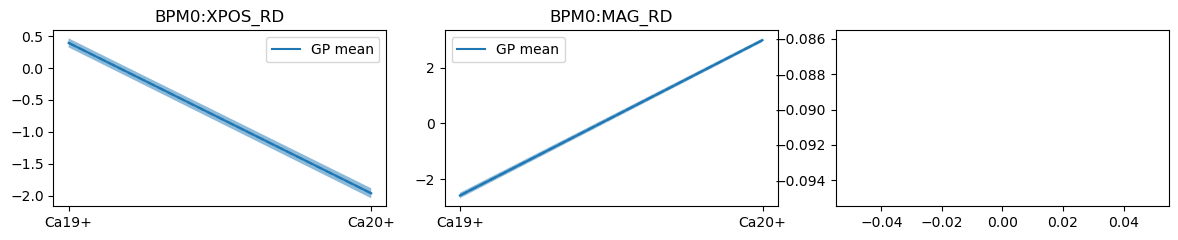

In [16]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["init"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )
    
    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 1st globalBO

In [17]:
with capture_warnings():
    msbo.optimize_global(neval=n_eval, beta=beta)
    candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=9.0)
    control_values = np.vstack((control_values,candidate))

In [18]:
# projection_plot(msbo,candidate)

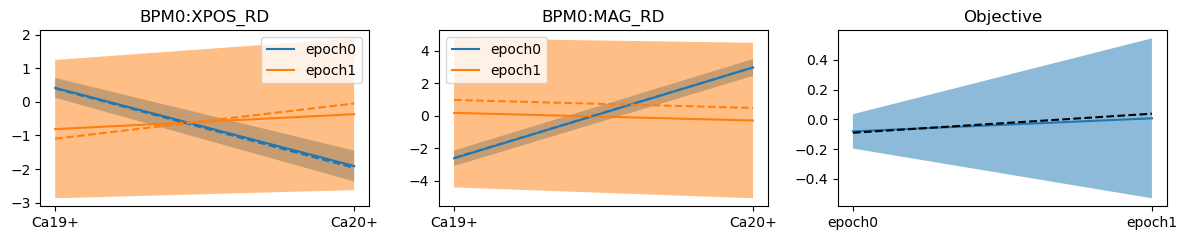

In [19]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["epoch0","epoch1"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )

    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 2nd globalBO

In [20]:
with capture_warnings():
    msbo.optimize_global(neval=n_eval, beta=beta)
    candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=4.0)
    control_values = np.vstack((control_values,candidate))

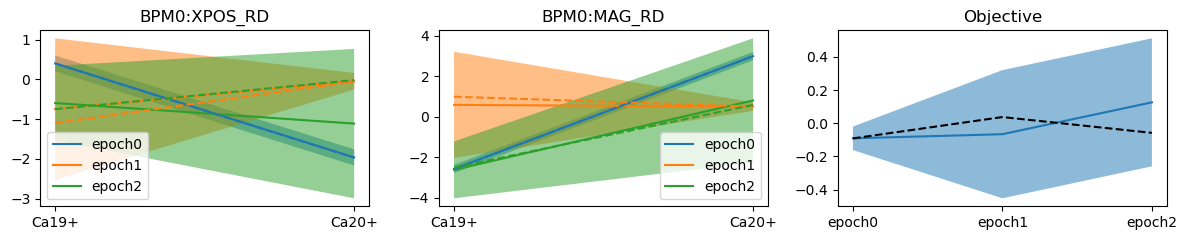

In [21]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["epoch0","epoch1","epoch2"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )

    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 3rd globalBO

In [22]:
with capture_warnings():
    msbo.optimize_global(neval=n_eval, beta=beta)
    candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=1.0)
    control_values = np.vstack((control_values,candidate))

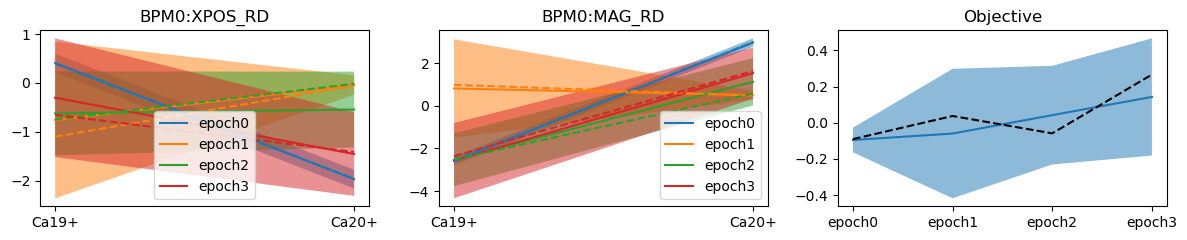

In [23]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["epoch0","epoch1","epoch2","epoch3"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )

    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

In [24]:
machineIO.history['df'].head()

,PSC0:I_CSET,PSC1:I_CSET,PSC2:I_CSET,PSC3:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,PSC2:I_RD,PSC3:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM0:MAG_RD
2025-02-02 14:50:45.170253,0.185147,0.781496,0.961469,0.712081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-02 14:50:45.370253,0.185147,0.781496,0.961469,0.712081,-16.0,0.092573,0.092573,0.185147,0.185465,0.781877,0.961878,0.712215,-15.999792,0.092927,0.093183,0.186132,0.397114,-2.586612
2025-02-02 14:50:45.570253,0.185147,0.781496,0.961469,0.712081,-16.0,0.092573,0.092573,0.185147,0.185683,0.781592,0.961726,0.712216,-15.999124,0.093085,0.093106,0.185916,0.397049,-2.586675
2025-02-02 14:50:45.770253,0.185147,0.781496,0.961469,0.712081,-16.0,0.092573,0.092573,0.185147,0.185386,0.782444,0.962440,0.712546,-15.999416,0.092607,0.092815,0.186141,0.397246,-2.586471
2025-02-02 14:50:45.970253,0.185147,0.781496,0.961469,0.712081,-16.0,0.092573,0.092573,0.185147,0.186136,0.782395,0.961978,0.712279,-15.999247,0.093421,0.092680,0.185936,0.396530,-2.584980


In [25]:
machineIO.history['df'].tail()

,PSC0:I_CSET,PSC1:I_CSET,PSC2:I_CSET,PSC3:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,PSC2:I_RD,PSC3:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM0:MAG_RD
2025-02-02 14:52:49.170253,0.0,1.0,0.490612,1.0,16.0,0.0,0.0,0.0,0.000201,1.000912,0.491103,1.000104,16.000597,0.000398,0.000069,0.000896,-1.412936,1.629553
2025-02-02 14:52:49.370253,0.0,1.0,0.490612,1.0,16.0,0.0,0.0,0.0,0.000962,1.000129,0.491109,1.000587,16.000542,0.000649,0.000937,0.000349,-1.414805,1.633855
2025-02-02 14:52:49.570253,0.0,1.0,0.490612,1.0,16.0,0.0,0.0,0.0,0.000588,1.000704,0.490767,1.000696,16.000031,0.000710,0.000577,0.000697,-1.412880,1.630181
2025-02-02 14:52:49.770253,0.0,1.0,0.490612,1.0,16.0,0.0,0.0,0.0,0.000729,1.000321,0.491519,1.000672,16.000063,0.000799,0.000226,0.000519,-1.414229,1.631978
2025-02-02 14:52:49.970253,0.0,1.0,0.490612,1.0,16.0,0.0,0.0,0.0,0.000571,1.000305,0.491223,1.000542,16.000522,0.000802,0.000432,0.000800,-1.413234,1.632579


In [26]:
msbo.msGP.l_train_X[0][:n_init]

tensor([[0.1856, 0.7815, 0.9618, 0.7129],
        [0.3684, 0.9546, 0.7483, 0.9985],
        [0.8710, 0.6344, 0.7757, 0.5327],
        [0.1527, 0.1262, 0.1072, 0.1566]], dtype=torch.float64)

In [27]:
msbo.msGP.l_train_X[0][n_init:n_init+n_eval]

tensor([[0.8657, 0.9048, 0.6098, 0.9455],
        [0.8282, 1.0005, 0.2151, 0.6288],
        [0.0266, 0.6983, 1.0005, 0.5359],
        [0.0209, 0.5472, 1.0007, 0.8651]], dtype=torch.float64)

In [28]:
msbo.msGP.l_train_X[0][n_init+n_eval:]

tensor([[6.7717e-04, 1.3371e-01, 1.0006e+00, 7.2318e-04],
        [9.4324e-04, 1.0005e+00, 1.9712e-01, 6.1719e-04],
        [1.0002e+00, 4.8207e-04, 1.8589e-04, 1.0009e+00],
        [3.2656e-04, 8.0159e-01, 1.3589e-04, 1.0005e+00],
        [4.2482e-01, 1.0003e+00, 1.0007e+00, 4.0312e-04],
        [1.0006e+00, 4.8198e-04, 1.0007e+00, 3.8125e-04],
        [1.0004e+00, 1.0003e+00, 1.0007e+00, 3.2347e-04],
        [4.4076e-01, 7.1378e-04, 1.0005e+00, 1.0005e+00]], dtype=torch.float64)